# Clean file with modules

In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from simspice.data.SproutDataset import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
import hdbscan

import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import simspice.utils.inverse_mapping_functions as imf
import simspice.models.Siamese_Architecture as SA

import umap.umap_ as umap
import tqdm

plt.rcParams['image.origin'] = 'lower'

BATCH_SIZE = 64

In [ ]:
path = 'C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\\Individual project\\SimSPICE\\'
path_feb23 = "C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\datasets_deepL\\spectra_Feb2023.nc"

In [ ]:
dataset_none = SproutDataset(dataset_path=path_feb23, augmentation_type=None) #spectra_train.nc for full dataset

In [3]:
checkpoint = "C:\\Users\\tania\Documents\CU Boulder\CU Alpine\models_ckpts\epoch=14-step=72600_double_cropped.ckpt"
outputs = SA.run_model(checkpoint, dataset_none)

Lightning automatically upgraded your loaded checkpoint from v1.9.3 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\tania\Documents\CU Boulder\CU Alpine\models_ckpts\epoch=14-step=72600_double_cropped.ckpt`
100%|██████████| 116160/116160 [03:38<00:00, 531.42it/s]


In [4]:
stacked_outputs = np.stack(outputs).squeeze()
stacked_outputs.shape 
np.save('C:\\Users\\tania\\Documents\\CU Boulder\\CU Fall 2024\\ASEN 6337\\Individual project\\SimSPICE\\model_runs\\fulltrained_feb23run_double64.npy', stacked_outputs)

In [4]:
stacked_outputs = np.load(path+'\\model_runs\\fulltrained_feb23run_double64.npy')

In [8]:
stacked_outputs.shape

(116160, 64)

### Test clustering with various parameters

In [10]:
for x in tqdm.tqdm([10, 20, 30]):
    for y in [2, 5, 10]:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean') #<=> cosine?
        clusterer.fit(stacked_outputs)
        labels = clusterer.labels_
        np.save(f'{path}clustering//fulltrained_feb23run_double64_minclus{x}_minsamp{y}.npy', labels)

100%|██████████| 3/3 [1:11:19<00:00, 1426.43s/it]


Unique Clusters: [-1  0  1  2  3  4]
Unique Clusters: [-1  0  1  2]
Unique Clusters: [-1  0  1]
Unique Clusters: [-1  0  1  2]
Unique Clusters: [-1  0  1  2  3]
Unique Clusters: [-1  0  1  2  3  4]
Unique Clusters: [-1  0  1]
Unique Clusters: [-1  0  1  2  3  4  5]
Unique Clusters: [-1  0  1  2]


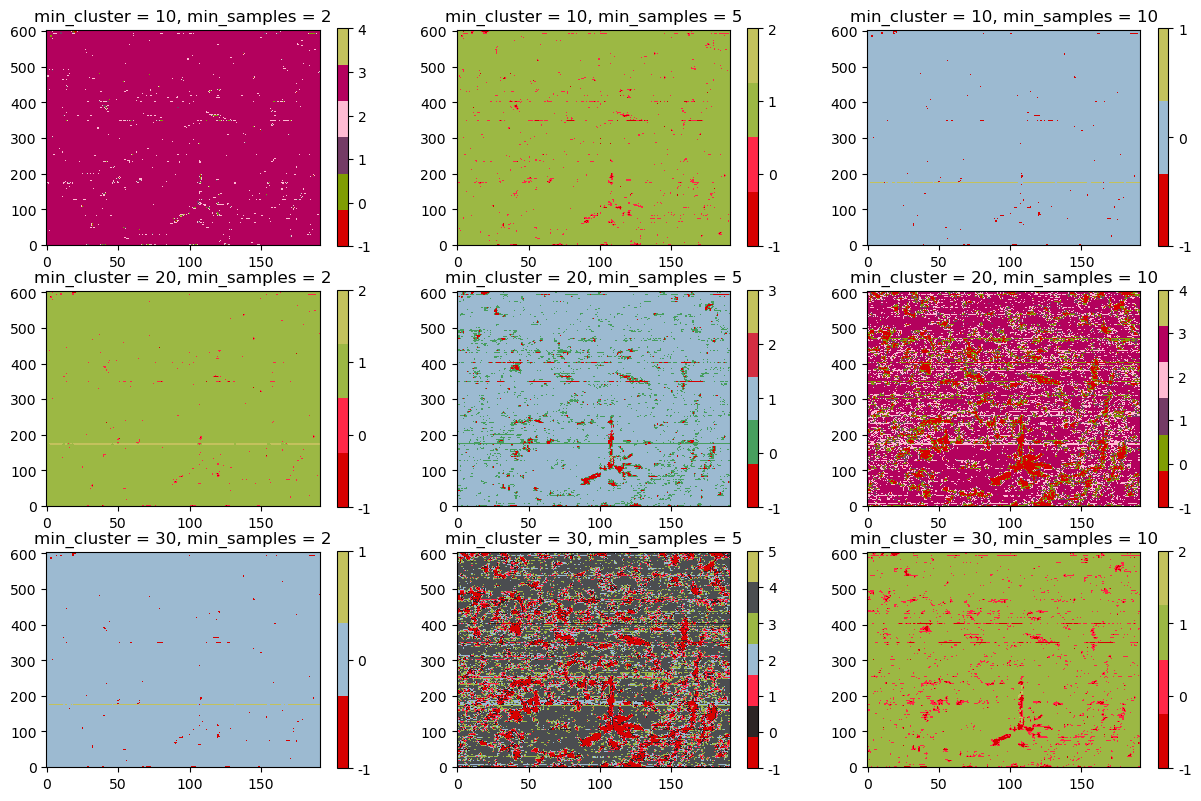

In [ ]:
c=0
plt.figure(figsize=(15,13))
for x in [10, 20, 30]:
    for y in [2, 5, 10]:
        c+=1
        plt.subplot(4,3,c)
        labels = np.load(f'{path}clustering//fulltrained_feb23run_double64_minclus{x}_minsamp{y}.npy')
        # labels = np.load(f'saved_outputs//labels_double_normspec_15epochs_Feb23_minclus{x}_minsamp{y}.npy') #best one so far
        imf.map_clusters(labels, dataset_path=path_feb23, selected_clusters=None)
        
        plt.title(f"min_cluster = {x}, min_samples = {y}")
# plt.suptitle('norm_15epochs_fullytrained_minclus_double')

### Plot average spectra for a single cluster

In [ ]:
x,y = (30,10)
labels = np.load(f'saved_outputs//labels_double_normspec_15epochs_Feb23_minclus{30}_minsamp{10}.npy')

In [ ]:
current_labels = labels.reshape(610, 192)
unique_clusters = np.unique(current_labels[~np.isnan(current_labels)])

In [ ]:
unique_clusters

In [ ]:
# imf.plot_n_random_spectra_cluster(labels, stacked_outputs, chosen_cluster=1, dataset=dataset_none, nbr_items=len(np.where(labels==1)[0]), plot_on_map=False, log_scale=False,
#                                   dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

#for i in unique_clusters:
av_spectra = imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=2, dataset=dataset_none, log_scale=False,
                                  dataset_path=path_feb23)

In [ ]:
len(av_spectra)

In [ ]:
from inverse_mapping_functions import WAVELENGTHS_ARRAY

In [ ]:
plt.figure(figsize=[12,4], tight_layout=True)
plt.plot(WAVELENGTHS_ARRAY, np.nanmean(av_spectra, axis=0), label = 'mean spectrum')
plt.plot(WAVELENGTHS_ARRAY, np.nanmedian(av_spectra, axis=0), alpha=0.5, label = 'median spectrum')
plt.xlabel('Wavelength ($\AA$)')
plt.title('Cluster #2')
plt.yscale('log')
plt.legend()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=[12, 4], tight_layout=True)
ax.plot(WAVELENGTHS_ARRAY, np.nanmean(av_spectra, axis=0), label='mean spectrum')
ax.plot(WAVELENGTHS_ARRAY, np.nanmedian(av_spectra, axis=0), alpha=0.5, label='median spectrum')
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_title('Cluster #2')
ax.legend()

# Add inset (e.g. zoom into 750-850 Å)
axins = inset_axes(ax, width="55%", height="65%", loc='upper left')
axins.plot(WAVELENGTHS_ARRAY, np.nanmean(av_spectra, axis=0))
axins.plot(WAVELENGTHS_ARRAY, np.nanmedian(av_spectra, axis=0), alpha=0.5)
axins.text(0.05, 0.8, 'Zoom on 700-800 $\AA$', transform=axins.transAxes, fontsize=15)
axins.set_xlim(700, 800)
axins.set_ylim(0, 1.2)
axins.set_xticks([])
axins.set_yticks([])

-------------------------------------------------------------------------------

In [ ]:
# # embedding_L2 = stacked_outputs / np.linalg.norm(stacked_outputs, ord=2)
# clusterer = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_epsilon=.5, metric='euclidean')
# clusterer.fit(stacked_outputs)
# labels = clusterer.labels_
# np.save('saved_outputs//clustered_outputs_double64_minidata_minclus10_minsamp5_eps05.npy', labels)

In [ ]:
# clusterer = hdbscan.hdbscan_.HDBSCAN(min_cluster_size=15, min_samples=5, cluster_selection_epsilon=.5, metric='euclidean')
# clusterer.fit(stacked_outputs)
# labels = clusterer.labels_
# np.save('saved_outputs//clustered_outputs_double64_minidata_minclus15_minsamp5_eps05.npy', labels)

In [ ]:
# labels = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus10_minsamp5_eps05.npy') 
# imf.map_clusters(labels, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

In [ ]:
plt.hist(labels, bins=np.arange(-1,np.max(labels)+2)-0.5, density=True, range=(-2,2)), plt.yscale('log');

## UMAP

In [ ]:
# reducer = umap.UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42)
# projected_data = reducer.fit_transform(stacked_outputs)
# np.save('saved_outputs//umap_data_64dou_minidataFeb11_neig30_dist001_10_2.npy', projected_data)

# # projected_data = np.load('saved_outputs//umap_data_64dou_fulldata_neig15_dist01.npy')
# # stacked_outputs = np.load('saved_outputs//stacked_outputs_double64_fulldata.npy')
# # labels = np.load('saved_outputs//clustered_outputs_double64_fulldata_minclus30_minsamp30.npy')
# projected_data = np.load('saved_outputs//umap_data_64dou_minidataFeb11_neig30_dist001_10_2.npy')

In [ ]:
from matplotlib.colors import Normalize

In [ ]:
labels = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus5_minsamp2_eps05.npy') 

In [ ]:
target_clusters = [0]  # List of cluster labels to plot
selected_points = projected_data[np.isin(labels, target_clusters)]
selected_labels = labels[np.isin(labels, target_clusters)]
norm = Normalize(vmin=labels.min(), vmax=labels.max())

plt.figure(figsize=(10, 6))
plt.scatter(selected_points[:, 0], selected_points[:, 1], c=selected_labels, cmap='tab20', norm=norm, s=3)
plt.title(f"Scatter Plot for Clusters {target_clusters}\nn_neighbors=15, min_dist=0.1\nmin_cluster_size=50, min_samples=5")
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(10, 14))
plt.subplot(211)
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='tab20', s=1)
plt.colorbar()
plt.title('UMAP Projection to 2D - double augmentation')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.subplot(212)
plt.hist2d(projected_data[:, 0], projected_data[:, 1], bins=200)
plt.colorbar()
plt.grid(True)
plt.title('Density histogram')
plt.show()

In [ ]:
labels01 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps0point1.npy')
labels1 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps1.npy') 
labels05 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps0point5.npy')
labels0 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps0.npy')
labels2 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps2.npy')
labels10 = np.load('saved_outputs\clustered_outputs_double64_minidata_minclus50_minsamp5_eps10.npy')

In [ ]:
print('0.5')
imf.map_clusters(labels05, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('0.1')
imf.map_clusters(labels01, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('1')
imf.map_clusters(labels1, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('0')
imf.map_clusters(labels0, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('2')
imf.map_clusters(labels2, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")
print('10')
imf.map_clusters(labels10, selected_clusters = None, dataset_path="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc")

In [ ]:
imf.map_item_map(item_nbr=1120, dataset="C:\\Users\\tania\\Documents\\SPICE\\SPROUTS\\spectra_11Feb2023.nc", plot=True, title='2023-02-11 T 15:35:40')